In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install tensorflow --quiet

import re
import string
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab', quiet=True)
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:


train_df = pd.read_csv("/content/drive/MyDrive/DrugReviewDataset/drug_review_train.csv")
val_df   = pd.read_csv("/content/drive/MyDrive/DrugReviewDataset/drug_review_validation.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/DrugReviewDataset/drug_review_test.csv")

In [ ]:
train_df.head(15)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74
5,5,218554,Tri-Sprintec,birth control,"""used for birth control and period issues- ver...",2.0,"January 7, 2017",4,57
6,6,207442,Suprep Bowel Prep Kit,bowel preparation,"""my prep instructions were one 6oz bottle the ...",8.0,"December 5, 2016",18,86
7,7,63753,Epiduo,acne,"""love it. i had the worst breakouts, so i got ...",9.0,"October 19, 2011",20,63
8,8,140845,Escitalopram,depression,"""i felt a positive difference within the first...",9.0,"April 21, 2016",13,49
9,9,182520,Mirena,birth control,"""i have been on mirena for over a year now and...",1.0,"June 15, 2009",45,37


In [ ]:
# Select only the 'review' and 'rating' columns
train_df = train_df[['review', 'rating']]
val_df = val_df[['review', 'rating']]
test_df = test_df[['review', 'rating']]

In [ ]:
train_df.head(25)

,review,rating
0,"""i have used restasis for about a year now and...",2.0
1,"""my experience has been somewhat mixed. i have...",7.0
2,"""this is my second implanon would not recommen...",1.0
3,"""i recommend taking as prescribed, and the bot...",10.0
4,"""i have been on ampyra for 5 days and have bee...",9.0
5,"""used for birth control and period issues- ver...",2.0
6,"""my prep instructions were one 6oz bottle the ...",8.0
7,"""love it. i had the worst breakouts, so i got ...",9.0
8,"""i felt a positive difference within the first...",9.0
9,"""i have been on mirena for over a year now and...",1.0


In [ ]:
print(train_df.info())
print(val_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110811 entries, 0 to 110810
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   review  110811 non-null  object 
 1   rating  110811 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27703 entries, 0 to 27702
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  27703 non-null  object 
 1   rating  27703 non-null  float64
dtypes: float64(1), object(1)
memory usage: 433.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46108 entries, 0 to 46107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  46108 non-null  object 
 1   rating  46108 non-null  float64
dtypes: float64(1), object(1)
memory usage: 720.6+ KB
None


In [ ]:
print(train_df.isnull().sum())
print(val_df.isnull().sum())
print(test_df.isnull().sum())

review    0
rating    0
dtype: int64
review    0
rating    0
dtype: int64
review    0
rating    0
dtype: int64


In [ ]:
def sentiments_label(rating):
    if rating >= 7:
        return 'positive'
    elif rating >= 4:
        return 'neutral'
    else:
        return 'negative'

# Apply sentiment labeling (corrected)
train_df['sentiment'] = train_df['rating'].apply(sentiments_label)
val_df['sentiment'] = val_df['rating'].apply(sentiments_label)
test_df['sentiment'] = test_df['rating'].apply(sentiments_label)

In [ ]:
print(train_df[['rating', 'sentiment']].head())

   rating sentiment
0     2.0  negative
1     7.0  positive
2     1.0  negative
3    10.0  positive
4     9.0  positive


In [ ]:
train_df = train_df.drop('rating', axis=1)
val_df = val_df.drop('rating', axis=1)
test_df = test_df.drop('rating', axis=1)

In [ ]:
train_df

train_df.head(10)

,review,sentiment
0,"""i have used restasis for about a year now and...",negative
1,"""my experience has been somewhat mixed. i have...",positive
2,"""this is my second implanon would not recommen...",negative
3,"""i recommend taking as prescribed, and the bot...",positive
4,"""i have been on ampyra for 5 days and have bee...",positive
5,"""used for birth control and period issues- ver...",negative
6,"""my prep instructions were one 6oz bottle the ...",positive
7,"""love it. i had the worst breakouts, so i got ...",positive
8,"""i felt a positive difference within the first...",positive
9,"""i have been on mirena for over a year now and...",negative


In [ ]:
train_df.describe()

,review,sentiment
count,110811,110811
unique,84138,3
top,"""was on junel fe and it worked according to my...",positive
freq,4,73638


In [ ]:
train_df['sentiment'].value_counts()

,count
sentiment,
positive,73638
negative,23602
neutral,13571


In [ ]:
print(f"New dataset size: {train_df.shape}")

New dataset size: (110811, 2)


In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [ ]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
# def lemmatize_text(text):
#     lemmatizer = WordNetLemmatizer()
#     words = word_tokenize(text)
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
#     return " ".join(lemmatized_words)

def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    return " ".join([ps.stem(word) for word in words])

In [ ]:
def clean_text(text):
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [ ]:


train_df['clean_review'] = train_df['review'].apply(clean_text)
val_df['clean_review'] = val_df['review'].apply(clean_text)
test_df['clean_review'] = test_df['review'].apply(clean_text)

print(train_df[['review', 'clean_review']].head())

                                              review  \
0  "i have used restasis for about a year now and...   
1  "my experience has been somewhat mixed. i have...   
2  "this is my second implanon would not recommen...   
3  "i recommend taking as prescribed, and the bot...   
4  "i have been on ampyra for 5 days and have bee...   

                                        clean_review  
0  use restasi year seen almost progress life red...  
1  experi somewhat mix use implanon nearli 14 mon...  
2  second implanon would recommend first one okay...  
3  recommend take prescrib bottl usual say take x...  
4  ampyra 5 day happi new pill first 2 day good s...  


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['sentiment'])
val_df['sentiment_encoded'] = label_encoder.transform(val_df['sentiment'])
test_df['sentiment_encoded'] = label_encoder.transform(test_df['sentiment'])
print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [ ]:
# Tokenization and padding
max_words = 10000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_review'])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_review']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_df['clean_review']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['clean_review']), maxlen=max_len)
y_train = train_df['sentiment_encoded'].values
y_val = val_df['sentiment_encoded'].values
y_test = test_df['sentiment_encoded'].values

In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (110811, 150)
X_val shape: (27703, 150)
X_test shape: (46108, 150)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model_rnn = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SimpleRNN(64),
    Dense(3, activation='softmax')
])
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn = model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.7187 - loss: 0.7218 - val_accuracy: 0.7582 - val_loss: 0.6242
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.7970 - loss: 0.5266 - val_accuracy: 0.7659 - val_loss: 0.6076
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.8536 - loss: 0.3971 - val_accuracy: 0.7918 - val_loss: 0.5962
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.8932 - loss: 0.3001 - val_accuracy: 0.7844 - val_loss: 0.6329
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.9176 - loss: 0.2344 - val_accuracy: 0.8033 - val_loss: 0.6266
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.9330 - loss: 0.1943 - val_accuracy: 0.8042 - val_loss: 0.6855
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.9433 - loss: 0.1639 - val_accuracy: 0.8106 - val_loss: 0.7231
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.9484 -

In [ ]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64),
    Dense(3, activation='softmax')
])
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.7384 - loss: 0.6662 - val_accuracy: 0.7680 - val_loss: 0.5849
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.8037 - loss: 0.4999 - val_accuracy: 0.7823 - val_loss: 0.5540
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.8426 - loss: 0.4073 - val_accuracy: 0.7969 - val_loss: 0.5311
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.8752 - loss: 0.3315 - val_accuracy: 0.8093 - val_loss: 0.5349
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9051 - loss: 0.2603 - val_accuracy: 0.8078 - val_loss: 0.5653
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.9289 - loss: 0.2004 - val_accuracy: 0.8275 - val_loss: 0.6102
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9485 - loss: 0.1518 - val_accuracy: 0.8305 - val_loss: 0.6424
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.9620 -

In [ ]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define max_words and max_len for the embedding layer

model_bilstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dense(3, activation='softmax')
])
model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bilstm = model_bilstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - accuracy: 0.7412 - loss: 0.6619 - val_accuracy: 0.7757 - val_loss: 0.5699
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 57s 16ms/step - accuracy: 0.8038 - loss: 0.4991 - val_accuracy: 0.7831 - val_loss: 0.5476
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - accuracy: 0.8405 - loss: 0.4120 - val_accuracy: 0.7944 - val_loss: 0.5344
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.8735 - loss: 0.3368 - val_accuracy: 0.8076 - val_loss: 0.5423
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 57s 16ms/step - accuracy: 0.9028 - loss: 0.2611 - val_accuracy: 0.8163 - val_loss: 0.5607
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 57s 15ms/step - accuracy: 0.9299 - loss: 0.1966 - val_accuracy: 0.8237 - val_loss: 0.5913
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.9467 - loss: 0.1540 - val_accuracy: 0.8326 - val_loss: 0.6356
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 57s 15ms/step - accuracy: 0.9627 -

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)
model_attention = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    AttentionLayer(),
    Dense(3, activation='softmax')
])
model_attention.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_attention = model_attention.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.7290 - loss: 0.6927 - val_accuracy: 0.7745 - val_loss: 0.5660
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.8007 - loss: 0.5021 - val_accuracy: 0.7855 - val_loss: 0.5393
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.8326 - loss: 0.4267 - val_accuracy: 0.7944 - val_loss: 0.5332
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.8667 - loss: 0.3486 - val_accuracy: 0.8023 - val_loss: 0.5459
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.8952 - loss: 0.2797 - val_accuracy: 0.8077 - val_loss: 0.5779
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9196 - loss: 0.2222 - val_accuracy: 0.8155 - val_loss: 0.5900
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9395 - loss: 0.1698 - val_accuracy: 0.8216 - val_loss: 0.6836
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9546 -

In [ ]:
model_bilstm_attention = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    AttentionLayer(),
    Dense(3, activation='softmax')
])
model_bilstm_attention.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bilstm_attention = model_bilstm_attention.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 62s 16ms/step - accuracy: 0.7318 - loss: 0.6851 - val_accuracy: 0.7737 - val_loss: 0.5762
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.8021 - loss: 0.5027 - val_accuracy: 0.7835 - val_loss: 0.5418
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.8324 - loss: 0.4302 - val_accuracy: 0.7951 - val_loss: 0.5358
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.8690 - loss: 0.3455 - val_accuracy: 0.8053 - val_loss: 0.5262
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.8977 - loss: 0.2780 - val_accuracy: 0.8154 - val_loss: 0.5482
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9218 - loss: 0.2167 - val_accuracy: 0.8215 - val_loss: 0.6056
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 69s 19ms/step - accuracy: 0.9430 - loss: 0.1669 - val_accuracy: 0.8301 - val_loss: 0.6432
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9580 -

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, GRU

In [ ]:
model_cnn = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_cnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=30,
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3694/3694 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7349 - loss: 0.6719 - val_accuracy: 0.7862 - val_loss: 0.5463
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8417 - loss: 0.4067 - val_accuracy: 0.8227 - val_loss: 0.4872
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9195 - loss: 0.2187 - val_accuracy: 0.8277 - val_loss: 0.5315
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9612 - loss: 0.1107 - val_accuracy: 0.8383 - val_loss: 0.5913
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9781 - loss: 0.0649 - val_accuracy: 0.8495 - val_loss: 0.7133
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9839 - loss: 0.0463 - val_accuracy: 0.8244 - val_loss: 0.8650
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9858 - loss: 0.0384 - val_accuracy: 0.8488 - val_loss: 0.8279
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9892 - loss: 0.0299 - val

In [ ]:

model_gru = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    GRU(64),
    Dense(3, activation='softmax')
])

model_gru.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=30,
    verbose=1
)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.7340 - loss: 0.6790 - val_accuracy: 0.7661 - val_loss: 0.5875
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.8040 - loss: 0.5002 - val_accuracy: 0.7915 - val_loss: 0.5375
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.8440 - loss: 0.4070 - val_accuracy: 0.7995 - val_loss: 0.5303
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.8793 - loss: 0.3205 - val_accuracy: 0.8075 - val_loss: 0.5465
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9110 - loss: 0.2436 - val_accuracy: 0.8209 - val_loss: 0.5721
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.9371 - loss: 0.1800 - val_accuracy: 0.8297 - val_loss: 0.6168
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.9561 - loss: 0.1278 - val_accuracy: 0.8358 - val_loss: 0.6849
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9703 -

In [ ]:

model_bi_gru = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(GRU(64)),
    Dense(3, activation='softmax')
])

model_bi_gru.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

history_bi_gru = model_bi_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=30,
    verbose=1
)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - accuracy: 0.7402 - loss: 0.6664 - val_accuracy: 0.7759 - val_loss: 0.5640
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.8051 - loss: 0.4924 - val_accuracy: 0.7851 - val_loss: 0.5430
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.8419 - loss: 0.4080 - val_accuracy: 0.7956 - val_loss: 0.5340
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.8777 - loss: 0.3273 - val_accuracy: 0.8085 - val_loss: 0.5425
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.9081 - loss: 0.2531 - val_accuracy: 0.8174 - val_loss: 0.5726
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.9315 - loss: 0.1923 - val_accuracy: 0.8260 - val_loss: 0.6272
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.9511 - loss: 0.1386 - val_accuracy: 0.8310 - val_loss: 0.6978
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 57s 15ms/step - accuracy: 0.9675 -

In [ ]:
# --- Evaluation for all models ---

# RNN
val_loss_rnn, val_acc_rnn = model_rnn.evaluate(X_val, y_val, verbose=0)
test_loss_rnn, test_acc_rnn = model_rnn.evaluate(X_test, y_test, verbose=0)
print(f"RNN - Val Acc: {val_acc_rnn:.4f}, Test Acc: {test_acc_rnn:.4f}")

# LSTM
val_loss_lstm, val_acc_lstm = model_lstm.evaluate(X_val, y_val, verbose=0)
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"LSTM - Val Acc: {val_acc_lstm:.4f}, Test Acc: {test_acc_lstm:.4f}")

# BiLSTM
val_loss_bilstm, val_acc_bilstm = model_bilstm.evaluate(X_val, y_val, verbose=0)
test_loss_bilstm, test_acc_bilstm = model_bilstm.evaluate(X_test, y_test, verbose=0)
print(f"BiLSTM - Val Acc: {val_acc_bilstm:.4f}, Test Acc: {test_acc_bilstm:.4f}")

# Attention (LSTM + Attention)
val_loss_attention, val_acc_attention = model_attention.evaluate(X_val, y_val, verbose=0)
test_loss_attention, test_acc_attention = model_attention.evaluate(X_test, y_test, verbose=0)
print(f"Attention - Val Acc: {val_acc_attention:.4f}, Test Acc: {test_acc_attention:.4f}")

# BiLSTM + Attention
val_loss_bilstm_att, val_acc_bilstm_att = model_bilstm_attention.evaluate(X_val, y_val, verbose=0)
test_loss_bilstm_att, test_acc_bilstm_att = model_bilstm_attention.evaluate(X_test, y_test, verbose=0)
print(f"BiLSTM+Attention - Val Acc: {val_acc_bilstm_att:.4f}, Test Acc: {test_acc_bilstm_att:.4f}")

# CNN
val_loss_cnn, val_acc_cnn = model_cnn.evaluate(X_val, y_val, verbose=0)
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
print(f"CNN - Val Acc: {val_acc_cnn:.4f}, Test Acc: {test_acc_cnn:.4f}")

# GRU
val_loss_gru, val_acc_gru = model_gru.evaluate(X_val, y_val, verbose=0)
test_loss_gru, test_acc_gru = model_gru.evaluate(X_test, y_test, verbose=0)
print(f"GRU - Val Acc: {val_acc_gru:.4f}, Test Acc: {test_acc_gru:.4f}")

# BiGRU
val_loss_bi_gru, val_acc_bi_gru = model_bi_gru.evaluate(X_val, y_val, verbose=0)
test_loss_bi_gru, test_acc_bi_gru = model_bi_gru.evaluate(X_test, y_test, verbose=0)
print(f"BiGRU - Val Acc: {val_acc_bi_gru:.4f}, Test Acc: {test_acc_bi_gru:.4f}")


RNN - Val Acc: 0.8123, Test Acc: 0.8099
LSTM - Val Acc: 0.8431, Test Acc: 0.8443
BiLSTM - Val Acc: 0.8491, Test Acc: 0.8502
Attention - Val Acc: 0.8408, Test Acc: 0.8425
BiLSTM+Attention - Val Acc: 0.8478, Test Acc: 0.8457
CNN - Val Acc: 0.8508, Test Acc: 0.8489
GRU - Val Acc: 0.8416, Test Acc: 0.8396
BiGRU - Val Acc: 0.8399, Test Acc: 0.8375


1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


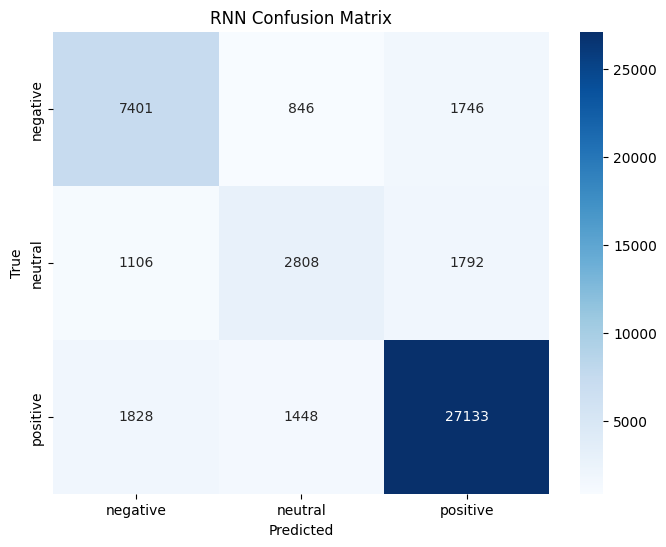

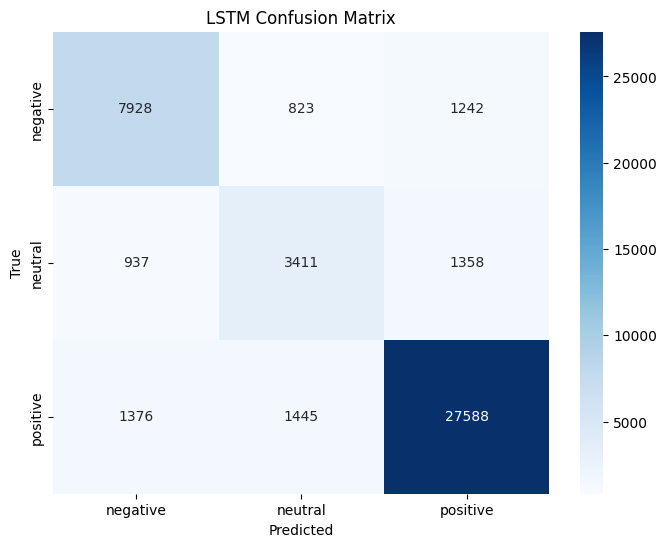

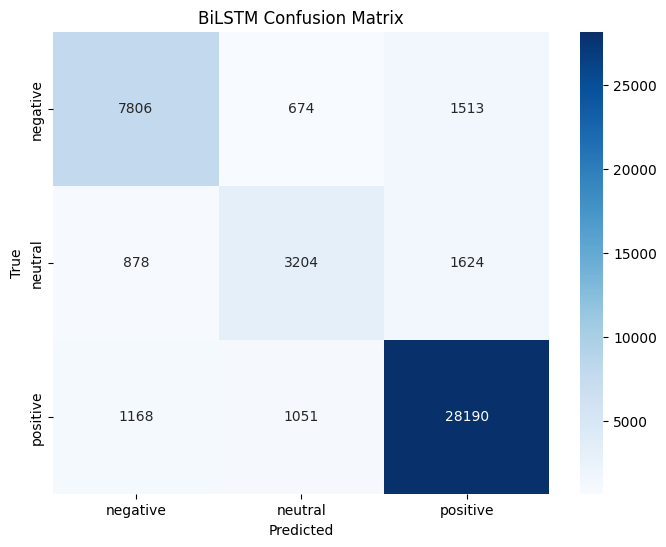

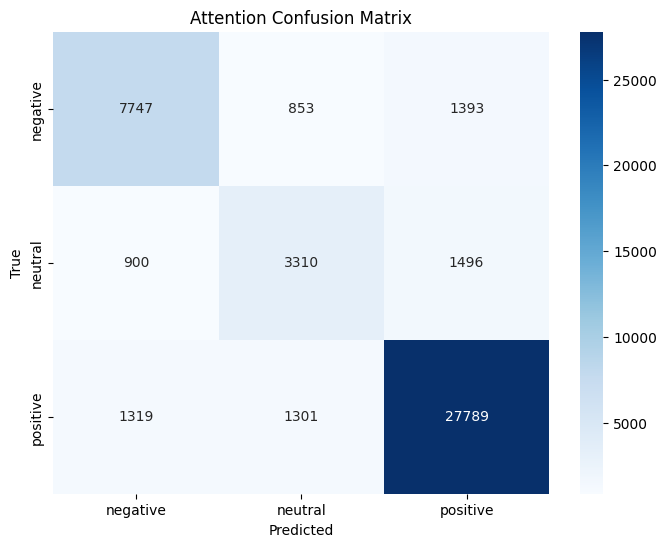

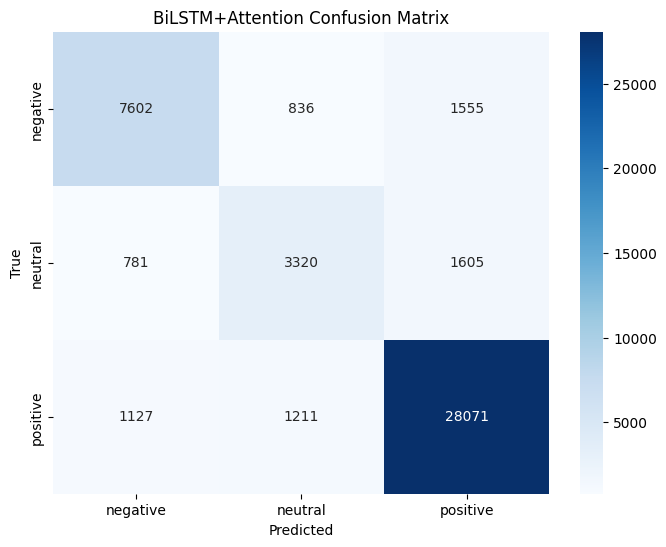

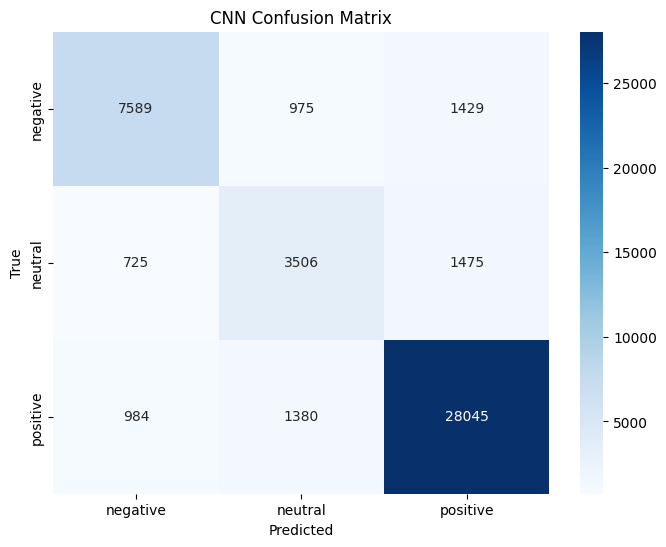

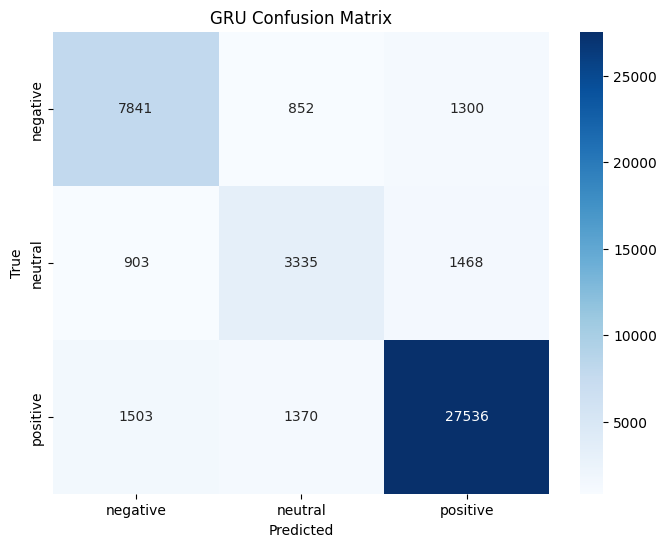

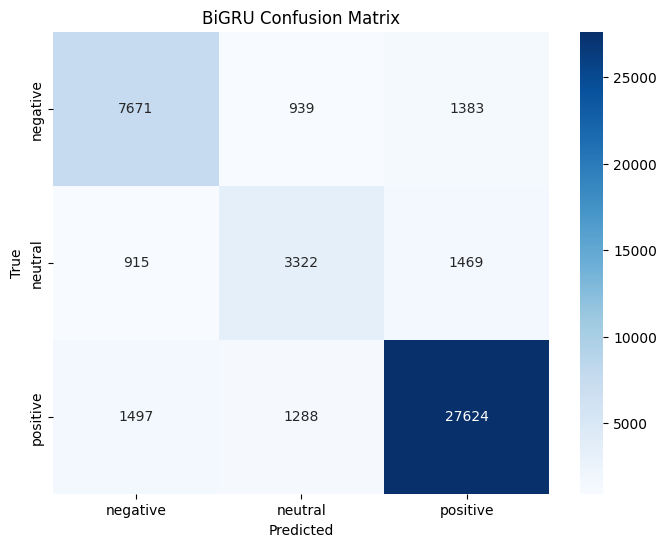

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
y_pred_rnn = np.argmax(model_rnn.predict(X_test), axis=1)
y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
y_pred_bilstm = np.argmax(model_bilstm.predict(X_test), axis=1)
y_pred_attention = np.argmax(model_attention.predict(X_test), axis=1)
y_pred_bilstm_att = np.argmax(model_bilstm_attention.predict(X_test), axis=1)
y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)
y_pred_gru = np.argmax(model_gru.predict(X_test), axis=1)
y_pred_bi_gru = np.argmax(model_bi_gru.predict(X_test), axis=1)

plot_confusion_matrix(y_test, y_pred_rnn, 'RNN Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_lstm, 'LSTM Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_bilstm, 'BiLSTM Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_attention, 'Attention Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_bilstm_att, 'BiLSTM+Attention Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_cnn, 'CNN Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_gru, 'GRU Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_bi_gru, 'BiGRU Confusion Matrix')


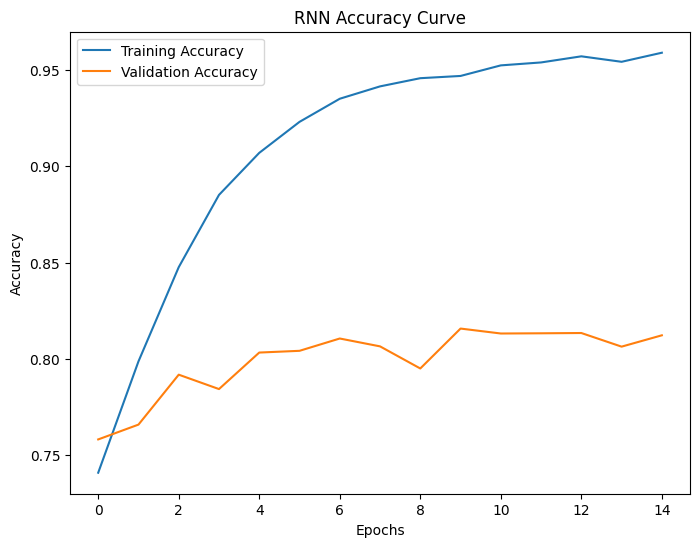

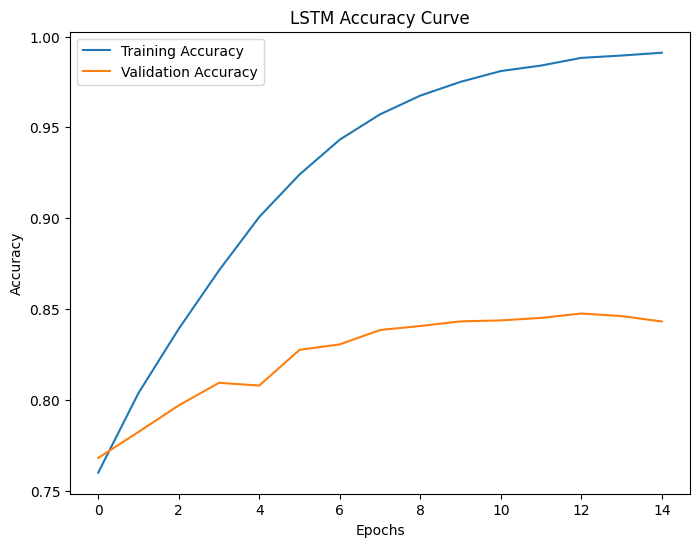

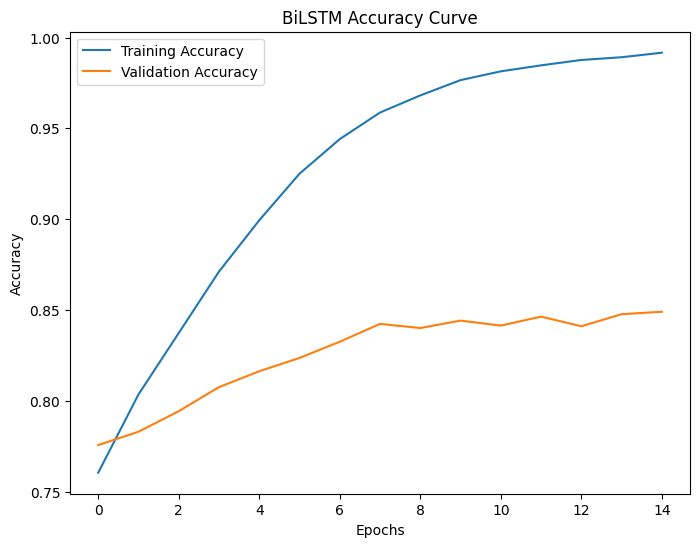

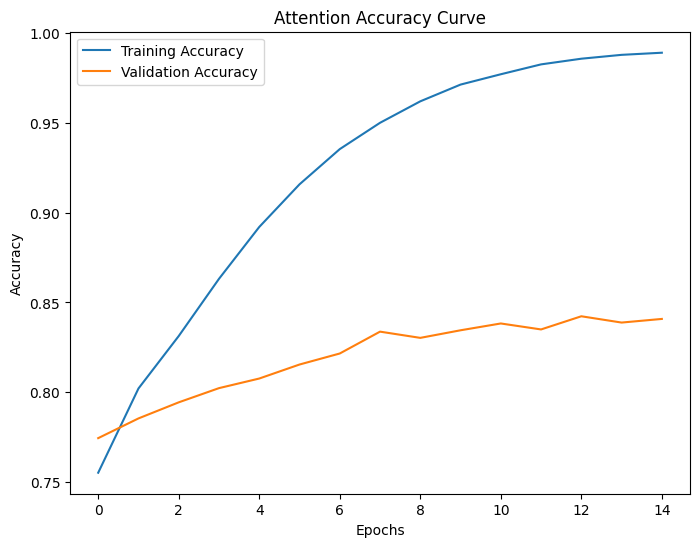

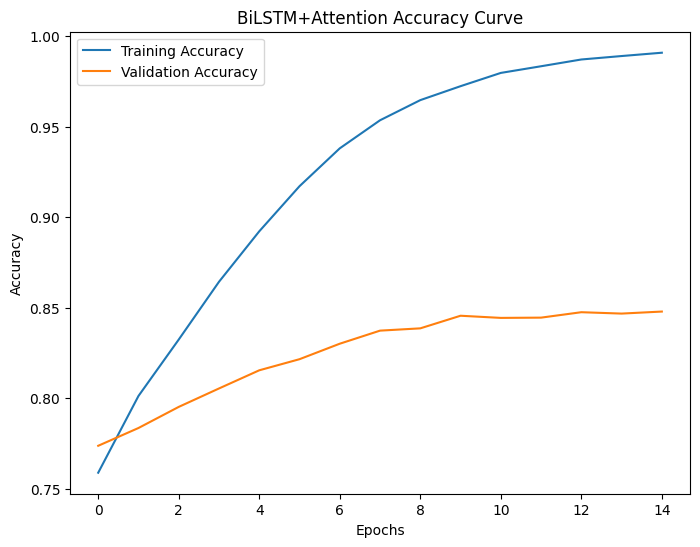

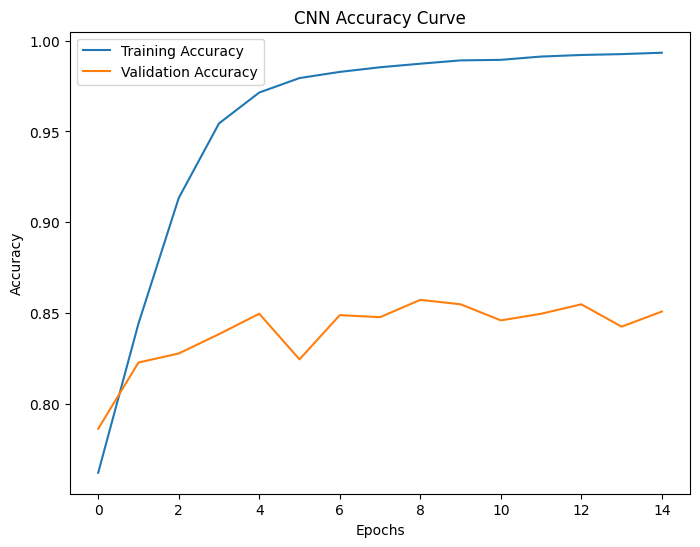

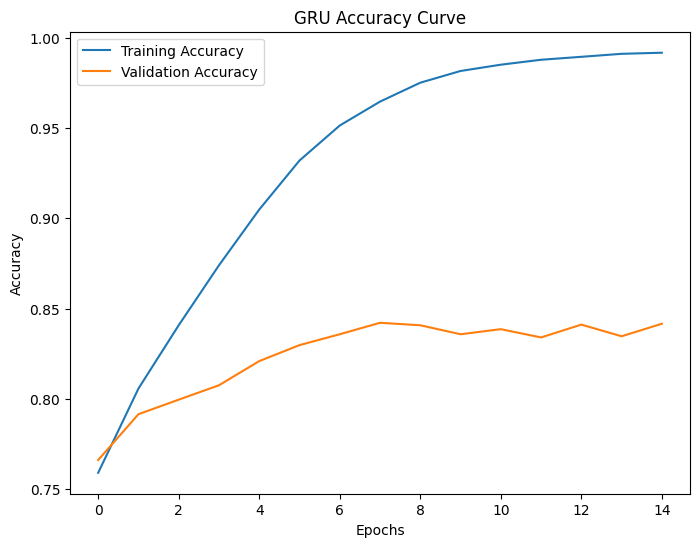

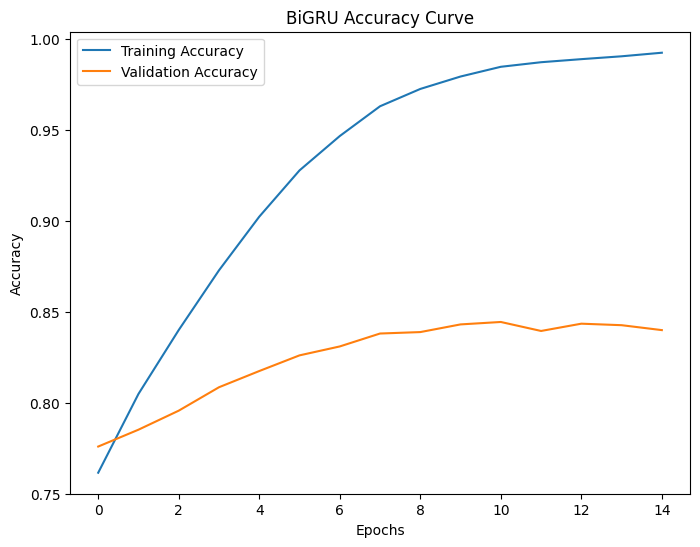

In [ ]:
def plot_accuracy_curve(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
     # Set y-axis range from 0 to 1 for accuracy
    plt.show()

# Plot accuracy curves for each model
plot_accuracy_curve(history_rnn, 'RNN Accuracy Curve')
plot_accuracy_curve(history_lstm, 'LSTM Accuracy Curve')
plot_accuracy_curve(history_bilstm, 'BiLSTM Accuracy Curve')
plot_accuracy_curve(history_attention, 'Attention Accuracy Curve')
plot_accuracy_curve(history_bilstm_attention, 'BiLSTM+Attention Accuracy Curve')
plot_accuracy_curve(history_cnn, 'CNN Accuracy Curve')
plot_accuracy_curve(history_gru, 'GRU Accuracy Curve')
plot_accuracy_curve(history_bi_gru, 'BiGRU Accuracy Curve')


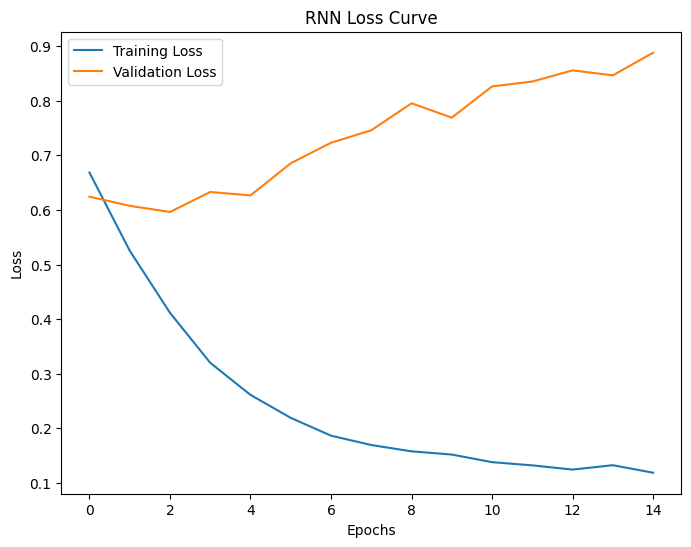

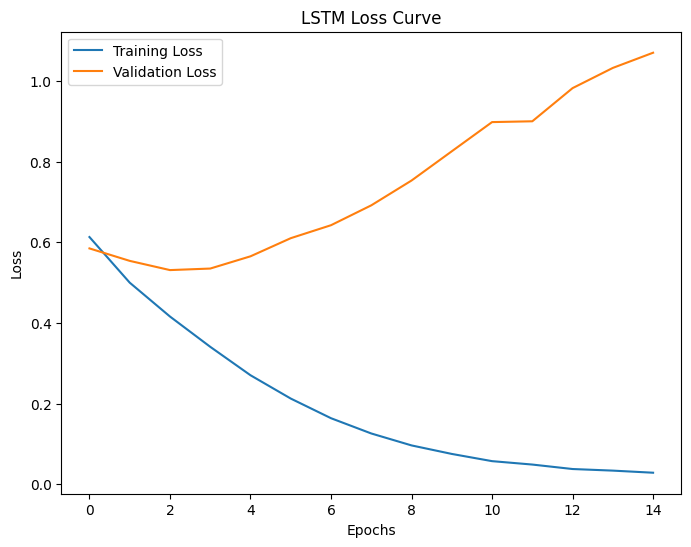

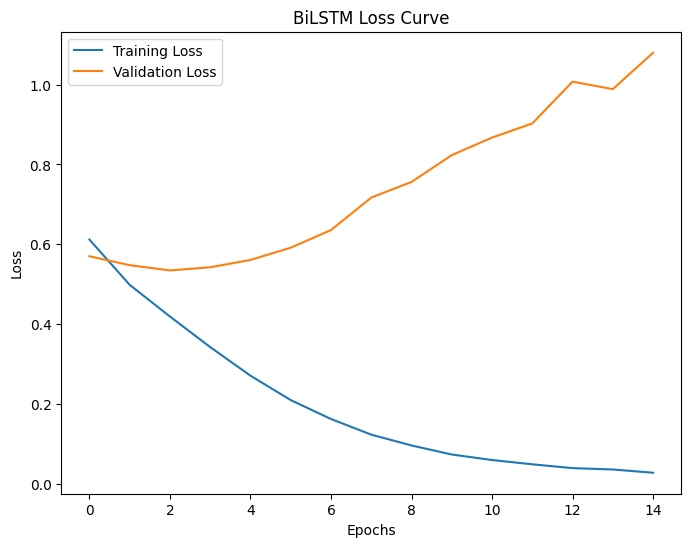

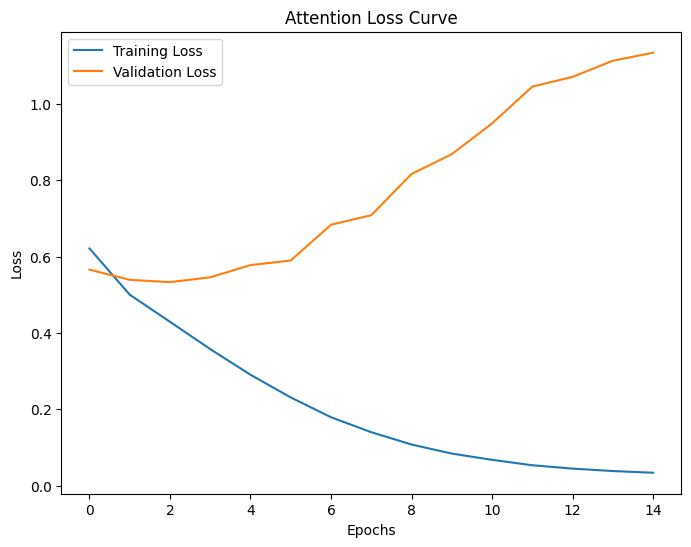

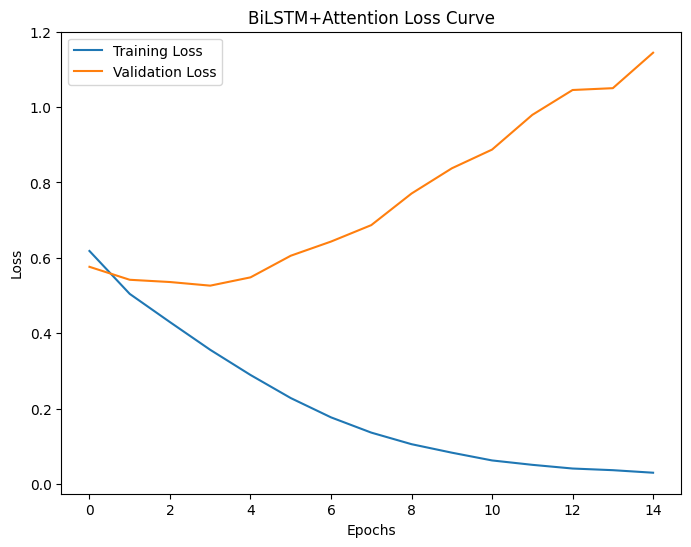

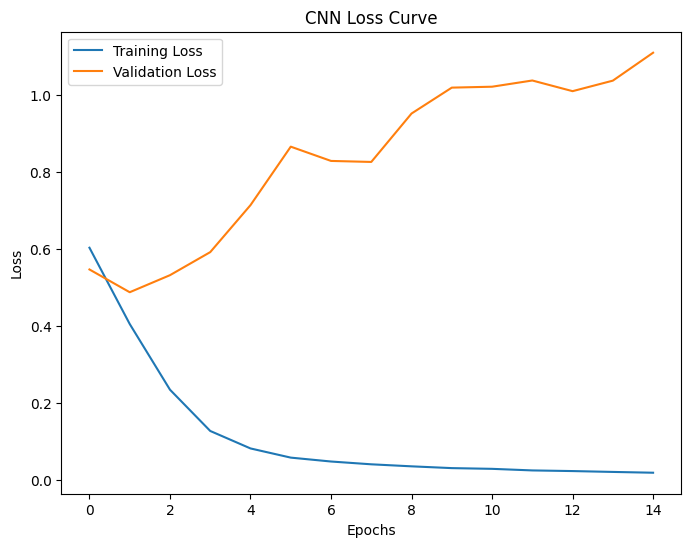

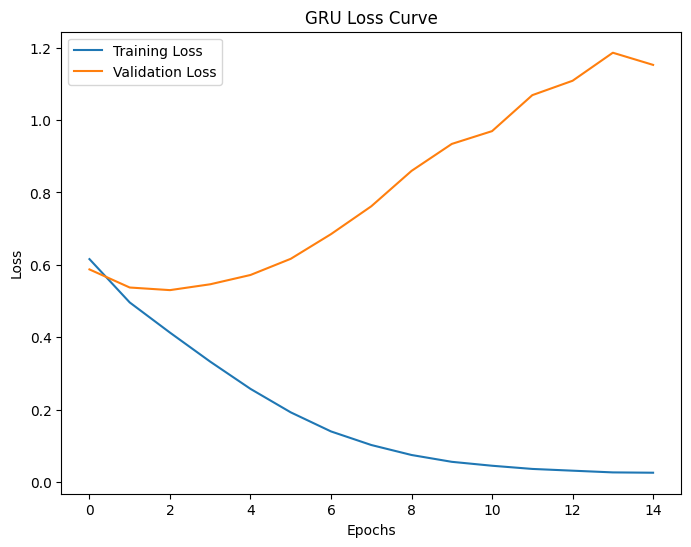

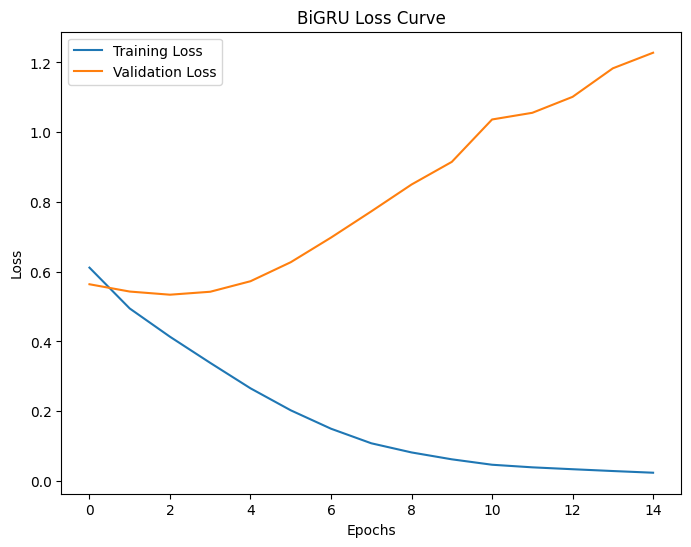

In [ ]:
def plot_loss_curve(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve(history_rnn, 'RNN Loss Curve')
plot_loss_curve(history_lstm, 'LSTM Loss Curve')
plot_loss_curve(history_bilstm, 'BiLSTM Loss Curve')
plot_loss_curve(history_attention, 'Attention Loss Curve')
plot_loss_curve(history_bilstm_attention, 'BiLSTM+Attention Loss Curve')
plot_loss_curve(history_cnn, 'CNN Loss Curve')
plot_loss_curve(history_gru, 'GRU Loss Curve')
plot_loss_curve(history_bi_gru, 'BiGRU Loss Curve')


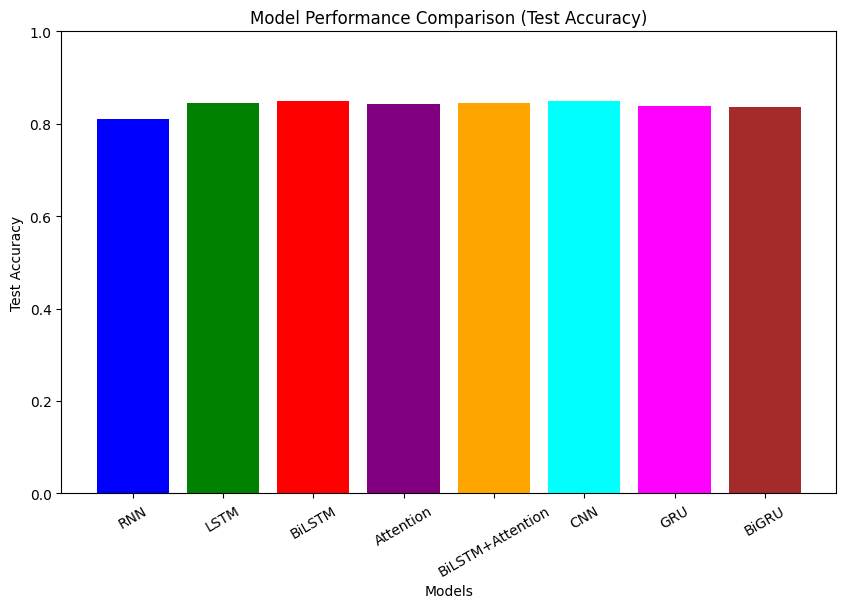

In [ ]:
models = [
    'RNN',
    'LSTM',
    'BiLSTM',
    'Attention',
    'BiLSTM+Attention',
    'CNN',
    'GRU',
    'BiGRU'
]

test_accuracies = [
    test_acc_rnn,
    test_acc_lstm,
    test_acc_bilstm,
    test_acc_attention,
    test_acc_bilstm_att,
    test_acc_cnn,
    test_acc_gru,
    test_acc_bi_gru
]

# Hardcoded colors – length MUST match len(models)
colors = [
    'blue',      # RNN
    'green',     # LSTM
    'red',       # BiLSTM
    'purple',    # Attention
    'orange',    # BiLSTM+Attention
    'cyan',      # CNN
    'magenta',   # GRU
    'brown'      # BiGRU
]

plt.figure(figsize=(10, 6))
plt.bar(models, test_accuracies, color=colors)
plt.title('Model Performance Comparison (Test Accuracy)')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()


In [ ]:
# ============================================================
#  ROC Curve for Each Model (Separate Curves Class-wise)
# ============================================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Convert test labels to one-hot (needed for multi-class ROC)
y_test_bin = label_binarize(y_test, classes=[0,1,2])
class_names = ["Negative","Neutral","Positive"]


def plot_roc_per_model(model, model_name):
    """Plots ROC curve for one model with AUC for 3 classes"""

    y_prob = model.predict(X_test)   # softmax probability output

    fpr = {}; tpr = {}; roc_auc = {}

    for i in range(3):  # 3 sentiment classes
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ------- PLOT -------
    plt.figure(figsize=(9,6))
    colors = ['red','blue','green']

    for i in range(3):
        plt.plot(fpr[i], tpr[i], color=colors[i],
                 label=f"{class_names[i]} AUC = {roc_auc[i]:.4f}")

    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

    print(f"\n📌 AUC Scores for {model_name}")
    for i in range(3):
        print(f"  {class_names[i]} = {roc_auc[i]:.4f}")
    print("========================================\n")

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


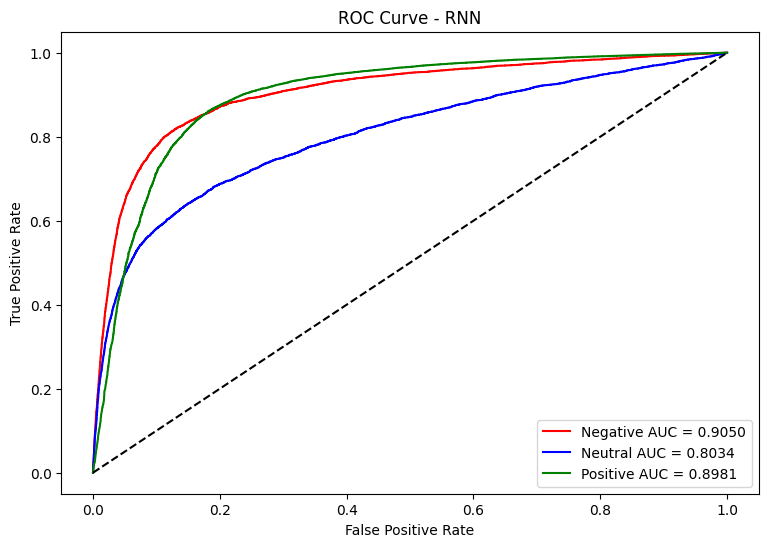


📌 AUC Scores for RNN
  Negative = 0.9050
  Neutral = 0.8034
  Positive = 0.8981

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


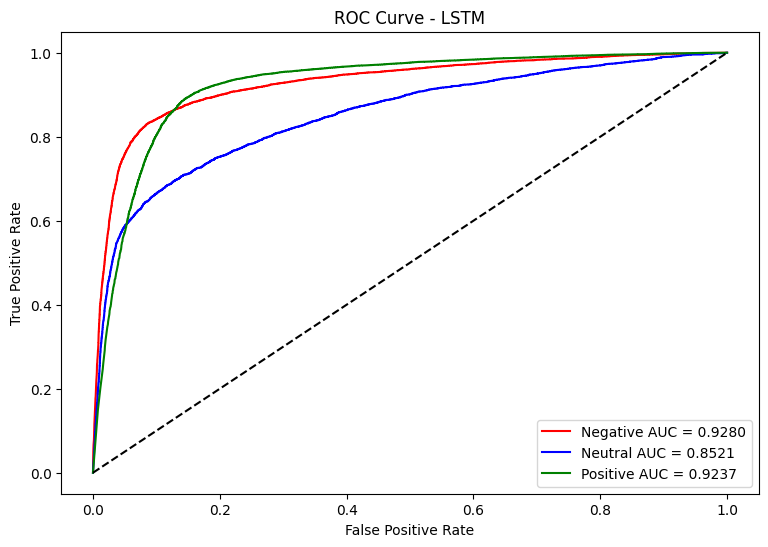


📌 AUC Scores for LSTM
  Negative = 0.9280
  Neutral = 0.8521
  Positive = 0.9237

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


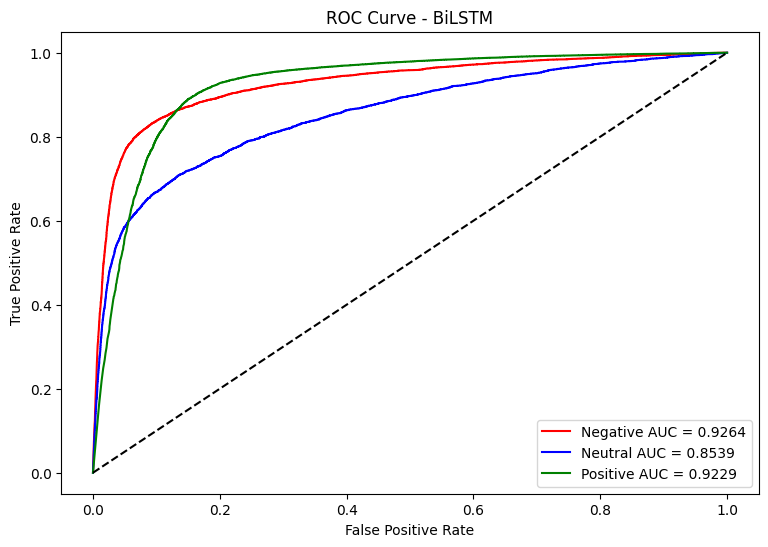


📌 AUC Scores for BiLSTM
  Negative = 0.9264
  Neutral = 0.8539
  Positive = 0.9229

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


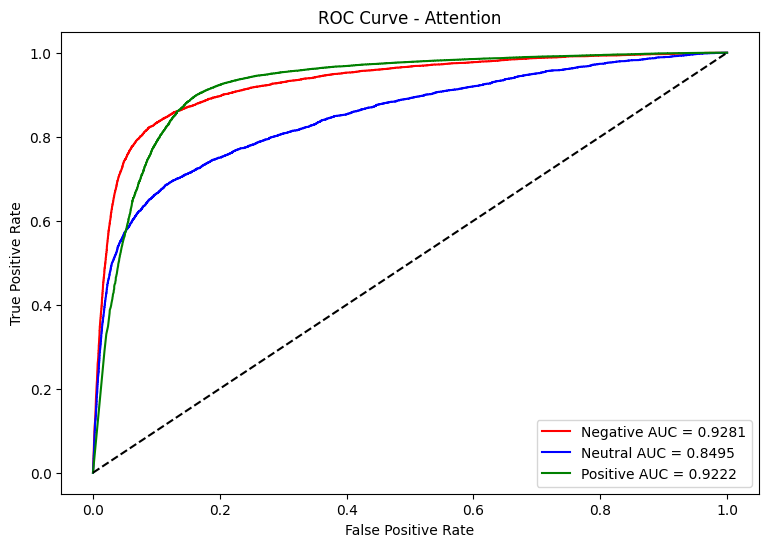


📌 AUC Scores for Attention
  Negative = 0.9281
  Neutral = 0.8495
  Positive = 0.9222

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


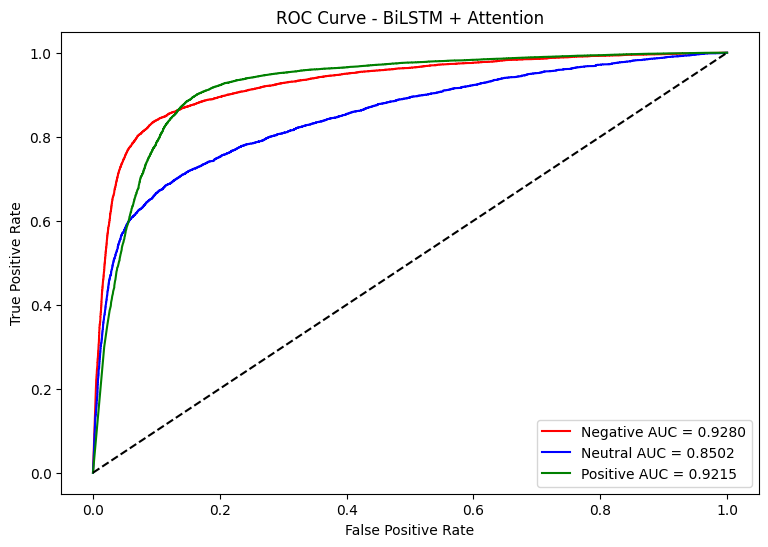


📌 AUC Scores for BiLSTM + Attention
  Negative = 0.9280
  Neutral = 0.8502
  Positive = 0.9215

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


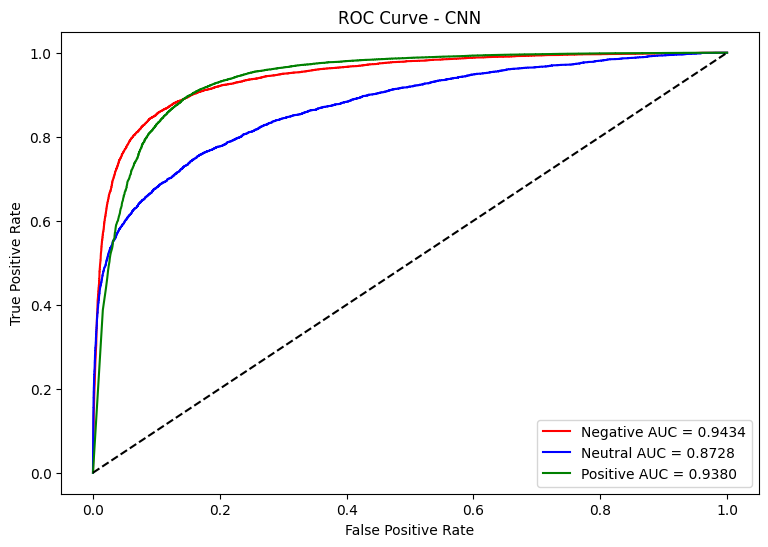


📌 AUC Scores for CNN
  Negative = 0.9434
  Neutral = 0.8728
  Positive = 0.9380

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


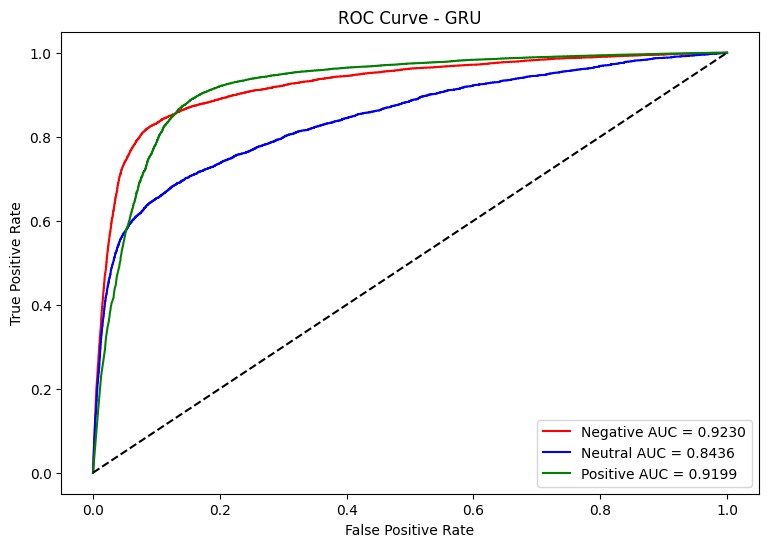


📌 AUC Scores for GRU
  Negative = 0.9230
  Neutral = 0.8436
  Positive = 0.9199

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


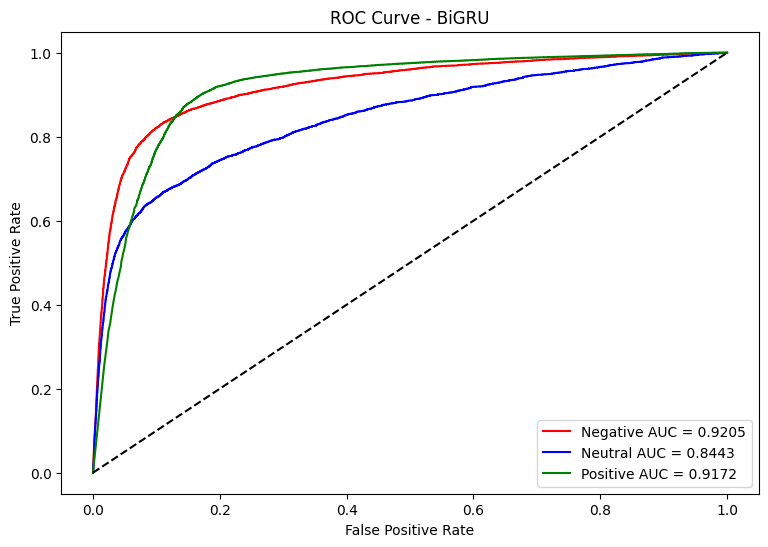


📌 AUC Scores for BiGRU
  Negative = 0.9205
  Neutral = 0.8443
  Positive = 0.9172



In [ ]:
plot_roc_per_model(model_rnn, "RNN")
plot_roc_per_model(model_lstm, "LSTM")
plot_roc_per_model(model_bilstm, "BiLSTM")
plot_roc_per_model(model_attention, "Attention")
plot_roc_per_model(model_bilstm_attention, "BiLSTM + Attention")
plot_roc_per_model(model_cnn, "CNN")
plot_roc_per_model(model_gru, "GRU")
plot_roc_per_model(model_bi_gru, "BiGRU")

In [ ]:
# ===================================================================
# 📌 FINAL METRICS COMPARISON TABLE FOR ALL MODELS
# ===================================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np

# Convert labels to one-hot for multi-class AUC
y_test_bin = label_binarize(y_test, classes=[0,1,2])

def evaluate_model(model):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_prob = model.predict(X_test)

    return {
        "Accuracy" : accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro'),
        "Recall"   : recall_score(y_test, y_pred, average='macro'),
        "F1 Score" : f1_score(y_test, y_pred, average='macro'),
        "ROC-AUC"  : roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    }


# All models for comparison
model_dict = {
    "RNN"                : model_rnn,
    "LSTM"               : model_lstm,
    "BiLSTM"             : model_bilstm,
    "Attention (LSTM)"   : model_attention,
    "BiLSTM + Attention" : model_bilstm_attention,
    "CNN"                : model_cnn,
    "GRU"                : model_gru,
    "BiGRU"              : model_bi_gru
}

# Build comparison table
results = {model_name: evaluate_model(model) for model_name, model in model_dict.items()}
df_results = pd.DataFrame(results).T

# Round for cleaner display
df_results = df_results.round(4)
print("\n🔶 MODEL PERFORMANCE COMPARISON TABLE 🔶")
df_results

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

🔶 MODEL PERFORMANCE COMPARISON TABLE 🔶


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
RNN,0.8099,0.7170,0.7083,0.7121,0.8688
LSTM,0.8443,0.7629,0.7661,0.7645,0.9013
BiLSTM,0.8502,0.7807,0.7566,0.7675,0.9011
Attention (LSTM),0.8425,0.7630,0.7564,0.7596,0.8999
BiLSTM + Attention,0.8457,0.7723,0.7552,0.7633,0.8999
CNN,0.8489,0.7735,0.7654,0.7690,0.9181
GRU,0.8396,0.7580,0.7582,0.7580,0.8955
BiGRU,0.8375,0.7553,0.7527,0.7540,0.8940


In [ ]:
!pip install gradio --quiet

In [ ]:
# =============================================
#  USE TRAINED MODEL TO FIND TOP DRUGS PER CONDITION
#  (No retraining, just prediction)
# =============================================

# Reload original dataset because you dropped condition + drugName
full_df = pd.read_csv("/content/drive/MyDrive/DrugReviewDataset/drug_review_train.csv")
# Keep only needed columns
full_df = full_df[['drugName','condition','review']].dropna()

# Apply SAME cleaning used in your model
full_df['clean_review'] = full_df['review'].apply(clean_text)

# Convert to sequences
X_all = pad_sequences(tokenizer.texts_to_sequences(full_df['clean_review']), maxlen=max_len)

# Select BEST MODEL (you may change)
best_model = model_bilstm_attention

# Predict sentiments using trained model
pred_all = np.argmax(best_model.predict(X_all), axis=1)
full_df['sentiment_pred'] = label_encoder.inverse_transform(pred_all)

# % sentiment distribution per drug per condition
result = (full_df.groupby(['condition','drugName'])['sentiment_pred']
          .value_counts(normalize=True)
          .unstack(fill_value=0) * 100)

# Top 3 drugs for each condition based on POSITIVE %
output = []
for cond in result.index.levels[0]:
    if cond in result.index:
        temp = result.loc[cond].sort_values(by='positive',ascending=False).head(3)
        for drug,row in temp.iterrows():
            output.append([
                cond, drug,
                round(row.get('positive',0),2),
                round(row.get('neutral',0),2),
                round(row.get('negative',0),2)
            ])

# Final Display
final_df = pd.DataFrame(output,columns=["Condition","Drug","Positive%","Neutral%","Negative%"])
print("\n================ BEST 3 DRUGS PER CONDITION ================\n")
print(final_df.head(30))  # show first 30 rows


NameError: name 'pd' is not defined